# GPLearn for Image Synthesis

## Imports

In [1]:
from gplearn.genetic import SymbolicRegressor
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils.validation import check_random_state
import graphviz
from sklearn.metrics import make_scorer
from gplearn.genetic import SymbolicRegressor
from gplearn.functions import make_function
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from gplearn.fitness import make_fitness
import os
import pickle
import sys
from utils.comparison import *
import contextlib
from PIL import Image

In [2]:
GENERATIONS= 20
POP_SIZE = 1000

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
def plot_fitness(estimator, gen_start, loss):
    fitness1 = estimator.run_details_["best_fitness"][gen_start:]

    # Plot all three
    plt.figure(figsize=(10, 6))
    plt.plot(fitness1, label='Estimator', color="red")

    plt.title(f"Best Fitness per Generation {loss}")
    plt.xlabel("Generation")
    plt.ylabel("Fitness")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

## Data

In [5]:
def safe_exp_exp(val):
    val = np.where(val > 700, 700, val)
    return np.exp(-np.exp(val))

def precalculate_xy(x, y):
    x2_y2 = x**2 + y**2
    sin_x = np.sin(x)
    cos_y = np.cos(y)
    sin_03x_07y = np.sin(0.3 * x - 0.7 * y)
    sin_03x_05y = np.sin(0.3 * x + 0.5 * y)
    return {
        "x2_y2": x2_y2,
        "sin_x": sin_x,
        "cos_y": cos_y,
        "sin_combo1": sin_03x_07y,
        "sin_combo2": sin_03x_05y
    }

def precalculate_D_B(cache):
    D_val = safe_exp_exp(cache["x2_y2"] - 1089)
    B_val = safe_exp_exp(cache["x2_y2"] - 1225) * \
            safe_exp_exp(-1000 * (cache["sin_combo1"] + 4 * cache["sin_combo2"]))
    return D_val, B_val

def Jc(D_val, B_val, cache, c):
    poly = -0.07 * c**2 + 0.18 * c + 0.88
    exp1 = safe_exp_exp(cache["x2_y2"] - (cache["x2_y2"] - cache["x2_y2"] + 20_000))
    exp2 = safe_exp_exp(-20 * (cache["sin_x"] + cache["cos_y"]))
    return (1 - D_val) * (1 - B_val) * poly * exp1 * exp2

def Ic(D_val, B_val, cache, c):
    poly = -0.02 * c**2 + 0.23 * c + 0.04
    exp = safe_exp_exp(10 * (cache["sin_x"] + cache["cos_y"]))
    return (1 - D_val) * (1 - B_val) * poly * exp

def Hc(D_val, B_val, c):
    poly = 0.15 * c**2 - 0.76 * c + 1.6
    return poly * B_val + (1 - B_val) * 0.93 * D_val

def Ac(x, y, c):
    cache = precalculate_xy(x, y)
    D_val, B_val = precalculate_D_B(cache)
    return 255 * (Hc(D_val, B_val, c) + Ic(D_val, B_val, cache, c) + Jc(D_val, B_val, cache, c))

def rgb(x, y, c):
    return Ac((x - 800) / 10, (500 - y) / 10, c)

In [6]:
width, height = 1600, 1000

m = np.linspace(1, width, width//5)
n = np.linspace(1, height, height//5)
m_grid, n_grid = np.meshgrid(m, n)

r = rgb(m_grid, n_grid, 1)
g = rgb(m_grid, n_grid, 2)
b = rgb(m_grid, n_grid, 3)

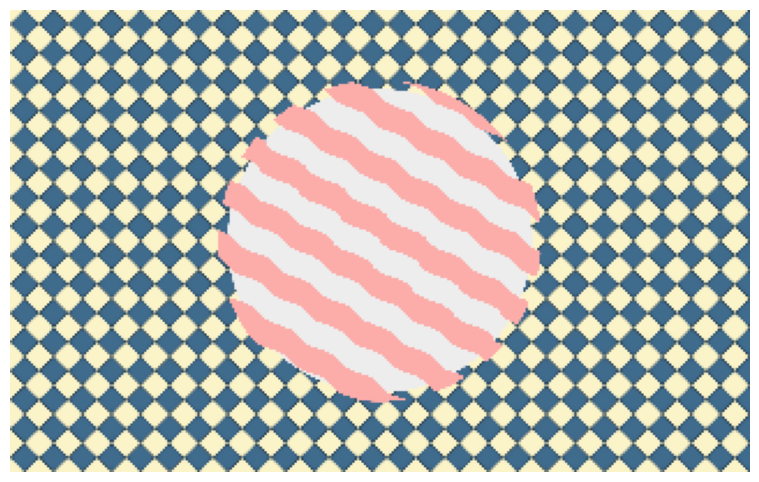

In [7]:
rgb_image = np.stack([r, g, b], axis=-1).astype(np.uint8)

plt.figure(figsize=(10, 6))
plt.imshow(rgb_image)
plt.axis('off')
plt.savefig('data/hard_2.png')
plt.show()

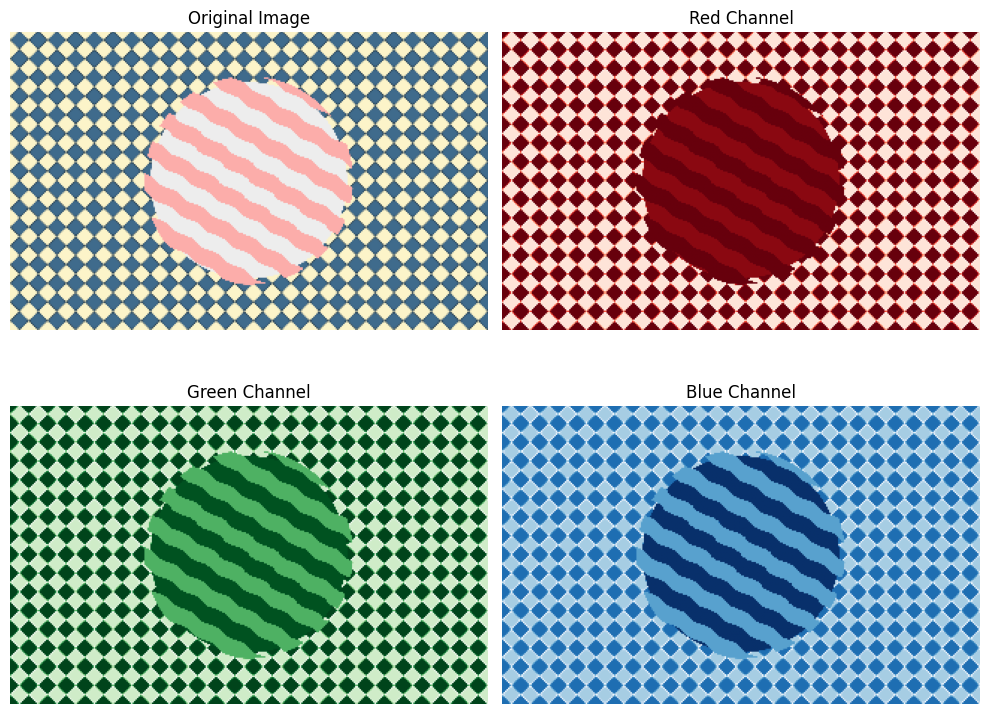

In [8]:
plt.figure(figsize=(10, 8))

# Original image
plt.subplot(2, 2, 1)
plt.imshow(rgb_image)
plt.title('Original Image')
plt.axis('off')

# Red channel
plt.subplot(2, 2, 2)
plt.imshow(r, cmap='Reds')
plt.title('Red Channel')
plt.axis('off')

# Green channel
plt.subplot(2, 2, 3)
plt.imshow(g, cmap='Greens')
plt.title('Green Channel')
plt.axis('off')

# Blue channel
plt.subplot(2, 2, 4)
plt.imshow(b, cmap='Blues')
plt.title('Blue Channel')
plt.axis('off')

plt.tight_layout()
plt.show()

## Experiments

In [9]:
@contextlib.contextmanager
def suppress_stderr():
    with open(os.devnull, 'w') as devnull:
        old_stderr = os.dup(2)
        os.dup2(devnull.fileno(), 2)
        try:
            yield
        finally:
            os.dup2(old_stderr, 2)
            os.close(old_stderr)

In [10]:
width, height = 1600, 1000
m = np.linspace(1, width, width // 5)
n = np.linspace(1, height, height // 5)
m_grid, n_grid = np.meshgrid(m, n)
xy_base = np.stack((m_grid.flatten(), n_grid.flatten()), axis=1)

colors = np.array([1, 2, 3])
xy_repeated = np.repeat(xy_base, len(colors), axis=0)
color_repeated = np.tile(colors, len(xy_base)).reshape(-1, 1)
xyc_train = np.hstack((xy_repeated, color_repeated))

H, W, _ = rgb_image.shape

print(xyc_train.shape)
print(xyc_train[:6])

(192000, 3)
[[1.         1.         1.        ]
 [1.         1.         2.        ]
 [1.         1.         3.        ]
 [6.01253918 1.         1.        ]
 [6.01253918 1.         2.        ]
 [6.01253918 1.         3.        ]]


In [11]:
np.seterr(divide='ignore', invalid='ignore')

def safe_sin(x):
    return np.sin(np.clip(x, -1e3, 1e3))

def safe_cos(x):
    return np.cos(np.clip(x, -1e3, 1e3))

def safe_square(x):
    return np.clip(x, -1e3, 1e3) ** 2

def safe_cube(x):
    return np.clip(x, -1e3, 1e3) ** 3

def safe_exp(x):
    x = np.where(x > 700, 700, x)
    return np.exp(x)

def x2_y2(x, y):
    return np.clip(x**2 + y**2, 0, 1e7)

def sin_03x_07y(x, y):
    return np.sin(np.clip(0.3 * x - 0.7 * y,  -1e3, 1e3))

def sin_03x_05y(x, y):
    return np.sin(np.clip(0.3 * x + 0.5 * y,  -1e3, 1e3))

def x_db_func(x, y):
    return safe_exp_exp(x2_y2(x, y) - 1089)

def y_db_func(x, y):
    return safe_exp_exp(x2_y2(x, y) - 1225) * safe_exp_exp(-1000 * (sin_03x_07y(x,y) + 4 * sin_03x_05y(x, y)))

def ac_func(x, y, c):
    return rgb(x, y , c)

def mul_255(x):
    return 255*x

def rescale_x(x):
    return (x - 800) / 10

def rescale_y(y):
    return (500 - y) / 10 

def jc_func(d_val, b_val, x, y, c):
    x = (x - 800) / 10
    y = (500 - y) / 10
    poly = -0.07 * c**2 + 0.18 * c + 0.88
    exp1 = safe_exp_exp(x2_y2(x, y) - (x2_y2(x, y) - x2_y2(x, y) + 20_000))
    exp2 = safe_exp_exp(-20 * (safe_sin(x) + safe_cos(y)))
    return (1 - d_val) * (1 - b_val) * poly * exp1 * exp2

def ic_func(d_val, b_val, x, y, c):
    x = (x - 800) / 10
    y = (500 - y) / 10
    poly = -0.02 * c**2 + 0.23 * c + 0.04
    exp = safe_exp_exp(10 * (safe_sin(x) + safe_cos(y)))
    return (1 - d_val) * (1 - b_val) * poly * exp

def hc_func(x, y, c):
    x = (x - 800) / 10
    y = (500 - y) / 10
    poly = 0.15 * c**2 - 0.76 * c + 1.6
    return poly * y + (1 - y) * 0.93 * x

exp = make_function(function=safe_exp, name="exp", arity=1)
exp_exp = make_function(function=safe_exp_exp, name="exp_exp", arity=1)
sin = make_function(function=safe_sin, name="sin", arity=1)
cos = make_function(function=safe_cos, name="cos", arity=1)
square = make_function(function=safe_square, name="square", arity=1)
cube = make_function(function=safe_cube, name="cube", arity=1)
x2_y2_func = make_function(function=x2_y2, name="x2y2", arity=2)
sin_03x_07y_func = make_function(function=sin_03x_07y, name="sin_03x_07y", arity=2)
sin_03x_05y_func = make_function(function=sin_03x_05y, name="sin_03x_05y", arity=2)
xdb = make_function(function=x_db_func, name="x_db_func", arity=2)
ydb = make_function(function=y_db_func, name="y_db_func", arity=2)
acc = make_function(function=ac_func, name="ac", arity=3)

jcc = make_function(function=jc_func, name="jc", arity=5)
icc = make_function(function=ic_func, name="ic", arity=5)
hcc = make_function(function=hc_func, name="hc", arity=3)

rescale_x_func = make_function(function=rescale_x, name="res_x", arity=1)
rescale_y_func = make_function(function=rescale_y, name="res_y", arity=1)
multipy_255 = make_function(function=mul_255, name="mul_255", arity=1)

def _SSIM(y, y_pred, w):
    if len(y_pred) < 10:
        return 0
    y = y.reshape(H, W, 3)
    y_pred = y_pred.reshape(H, W, 3)
    y_pred = np.nan_to_num(y_pred, nan=0.0)
    y_pred = np.clip(y_pred, 0, 255)
    y_pred = y_pred.astype(dtype=np.int8)
    y = y.astype(dtype=np.int8)
    return ssim(y, y_pred, channel_axis=2, data_range=255)

ssim_fitness = make_fitness(function=_SSIM, greater_is_better=True)

#function_set = ['add', 'sub', 'mul', sin, cos, square, cube, exp, exp_exp, x2_y2_func, sin_03x_05y_func, sin_03x_07y_func, jcc, xdb, ydb, icc, hcc, acc]
#function_setr = [acc]
function_setr = ['add', 'sub', 'mul', multipy_255, rescale_y_func, rescale_x_func, hcc, icc, jcc, xdb, ydb, sin, cos, sin_03x_05y_func, sin_03x_07y_func]

complete_est = SymbolicRegressor(metric=ssim_fitness, function_set=function_setr, population_size=POP_SIZE, generations=GENERATIONS, stopping_criteria=1.0,
        verbose=1, random_state=42, n_jobs=8, init_method='half and half', const_range = None, init_depth=(3, 10))

print(f"Training Complete Model: \n")
complete_est.fit(xyc_train, rgb_image.flatten())

Training Complete Model: 

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left


/tmp/ipykernel_26715/32183444.py:20: RuntimeWarning: overflow encountered in square
/tmp/ipykernel_26715/32183444.py:20: RuntimeWarning: overflow encountered in square
/tmp/ipykernel_26715/32183444.py:20: RuntimeWarning: overflow encountered in square


   0   618.65       0.00748704       81        0.0967869              N/A    164.49m
   1     9.20        0.0164322       83         0.102089              N/A      3.75m
   2     9.25        0.0293337       15         0.140473              N/A      4.40m
   3    10.74        0.0464135       15         0.140473              N/A      4.53m
   4    13.04        0.0758504       27          0.17485              N/A      4.89m
   5    12.85        0.0845808       11         0.195154              N/A      4.80m
   6    15.38        0.0994025       16          0.22028              N/A      5.02m
   7    17.49         0.126059       23          0.24637              N/A      5.12m
   8    18.27          0.14516       33         0.267701              N/A      5.09m
   9    21.12         0.165054       46          0.26955              N/A      5.22m
  10    22.24         0.171122       35         0.293415              N/A      5.12m
  11    25.95         0.187255       48         0.301078         

SymbolicRegressor(const_range=None,
                  function_set=['add', 'sub', 'mul',
                                <gplearn.functions._Function object at 0x7a29032e7680>,
                                <gplearn.functions._Function object at 0x7a29032e7590>,
                                <gplearn.functions._Function object at 0x7a29032e7020>,
                                <gplearn.functions._Function object at 0x7a29032e74d0>,
                                <gplearn.functions._Function object at 0x7a29032e5610>,
                                <gplearn.functions._Fun...
                                <gplearn.functions._Function object at 0x7a29032e5c70>,
                                <gplearn.functions._Function object at 0x7a290307f950>,
                                <gplearn.functions._Function object at 0x7a290307fe90>,
                                <gplearn.functions._Function object at 0x7a29032e5e80>,
                                <gplearn.functions._Function object at 0x7a29032e6660>],
                  init_depth=(3, 10),
                  metric=<gplearn.fitness._Fitness object at 0x7a29032e76b0>,
                  n_jobs=8, random_state=42, stopping_criteria=1.0, verbose=1)

## Results

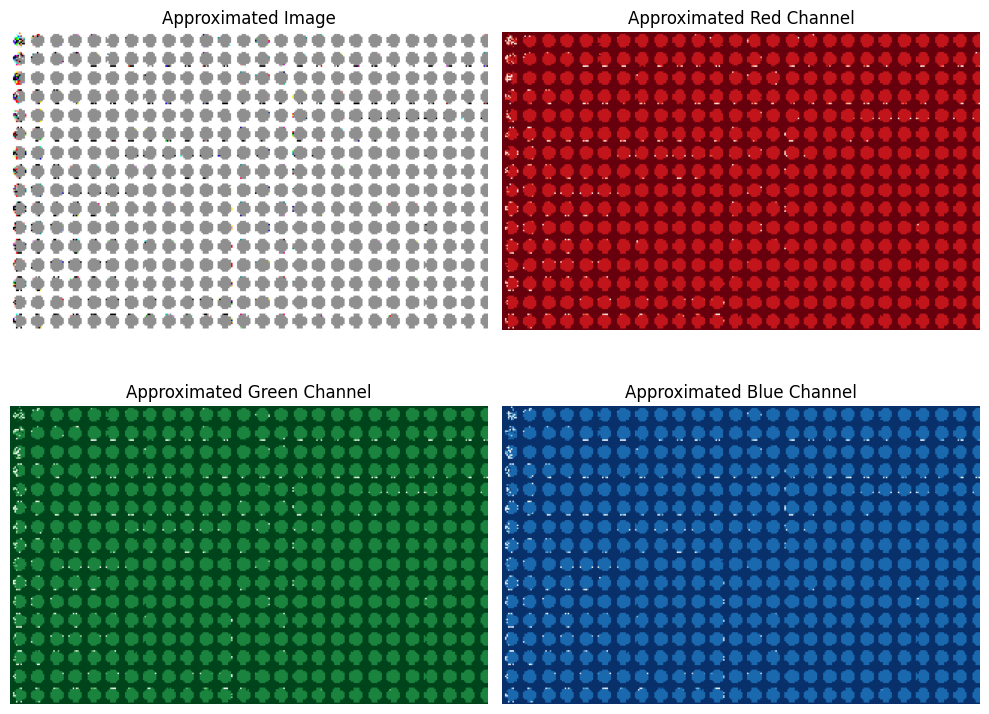

In [12]:
rgb_pred = complete_est.predict(xyc_train).reshape(H, W, 3)
r_pred = rgb_pred[:, :, 0]
g_pred = rgb_pred[:, :, 1]
b_pred = rgb_pred[:, :, 2]

rgb_pred = np.nan_to_num(rgb_pred, nan=0.0)
rgb_pred = np.clip(rgb_pred, 0, 255)
r_pred /= np.max(r_pred)
g_pred /= np.max(g_pred)
b_pred /= np.max(b_pred)
rgb_pred /= np.max(rgb_pred)

plt.figure(figsize=(10, 8))

plt.subplot(2, 2, 1)
plt.imshow(rgb_pred)
plt.title('Approximated Image')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(r_pred, cmap='Reds')
plt.title('Approximated Red Channel')
plt.axis('off')

plt.subplot(2, 2, 3)
plt.imshow(g_pred, cmap='Greens')
plt.title('Approximated Green Channel')
plt.axis('off')

plt.subplot(2, 2, 4)
plt.imshow(b_pred, cmap='Blues')
plt.title('Approximated Blue Channel')
plt.axis('off')

plt.tight_layout()
plt.show()

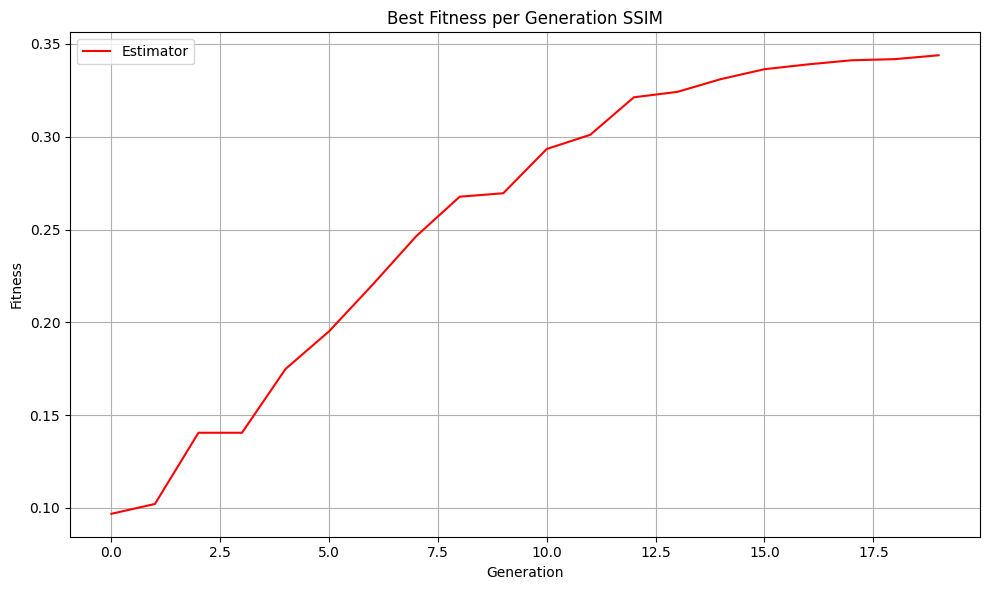

In [13]:
plot_fitness(complete_est, 0, "SSIM")

In [14]:
complete_est.set_params(metric = 'mean absolute error', generations = 40, warm_start = True)

print(f"Training Red MAE: \n")
complete_est.fit(xyc_train, rgb_image.flatten())

Training Red MAE: 

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
  20    17.88      5.82026e+25        8          46.3061              N/A     12.91m
  21    15.29      1.07879e+15       22          44.0958              N/A      8.37m
  22    14.82      6.53389e+18       24          43.8802              N/A      7.11m
  23    14.82      6.39576e+20       27          43.5518              N/A      7.21m
  24    25.45      1.72977e+23       38            42.35              N/A      7.61m
  25    33.77      1.23593e+11       32           42.291              N/A     10.38m
  26    44.20      1.76315e+13       27           42.025              N/A     12.30m
  27    43.27      1.53909e+21       44          41.8865              N/A     12.82m
  28    47.80      1.00244e+29       41          41.227

SymbolicRegressor(const_range=None,
                  function_set=['add', 'sub', 'mul',
                                <gplearn.functions._Function object at 0x7a29032e7680>,
                                <gplearn.functions._Function object at 0x7a29032e7590>,
                                <gplearn.functions._Function object at 0x7a29032e7020>,
                                <gplearn.functions._Function object at 0x7a29032e74d0>,
                                <gplearn.functions._Function object at 0x7a29032e5610>,
                                <gplearn.functions._Fun...
                                <gplearn.functions._Function object at 0x7a29032e5c70>,
                                <gplearn.functions._Function object at 0x7a290307f950>,
                                <gplearn.functions._Function object at 0x7a290307fe90>,
                                <gplearn.functions._Function object at 0x7a29032e5e80>,
                                <gplearn.functions._Function object at 0x7a29032e6660>],
                  generations=40, init_depth=(3, 10), n_jobs=8, random_state=42,
                  stopping_criteria=1.0, verbose=1, warm_start=True)

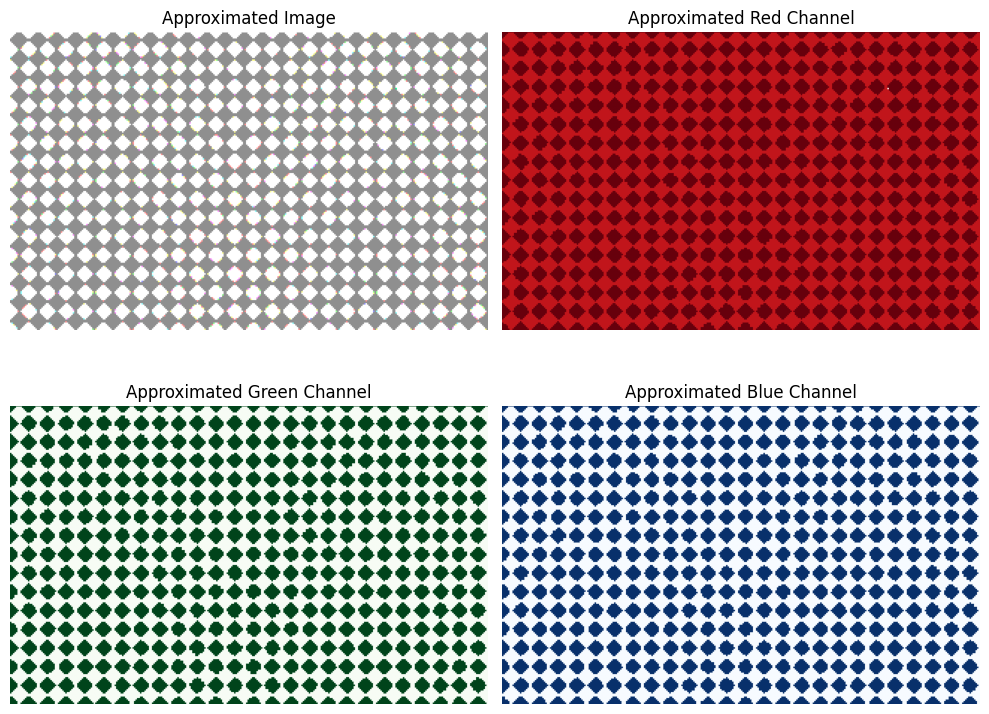

In [15]:
rgb_pred = complete_est.predict(xyc_train).reshape(H, W, 3)
r_pred = rgb_pred[:, :, 0]
g_pred = rgb_pred[:, :, 1]
b_pred = rgb_pred[:, :, 2]

rgb_pred = np.nan_to_num(rgb_pred, nan=0.0)
rgb_pred = np.clip(rgb_pred, 0, 255)
r_pred /= np.max(r_pred)
g_pred /= np.max(g_pred)
b_pred /= np.max(b_pred)
rgb_pred /= np.max(rgb_pred)

plt.figure(figsize=(10, 8))

plt.subplot(2, 2, 1)
plt.imshow(rgb_pred)
plt.title('Approximated Image')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(r_pred, cmap='Reds')
plt.title('Approximated Red Channel')
plt.axis('off')

plt.subplot(2, 2, 3)
plt.imshow(g_pred, cmap='Greens')
plt.title('Approximated Green Channel')
plt.axis('off')

plt.subplot(2, 2, 4)
plt.imshow(b_pred, cmap='Blues')
plt.title('Approximated Blue Channel')
plt.axis('off')

plt.tight_layout()
plt.show()

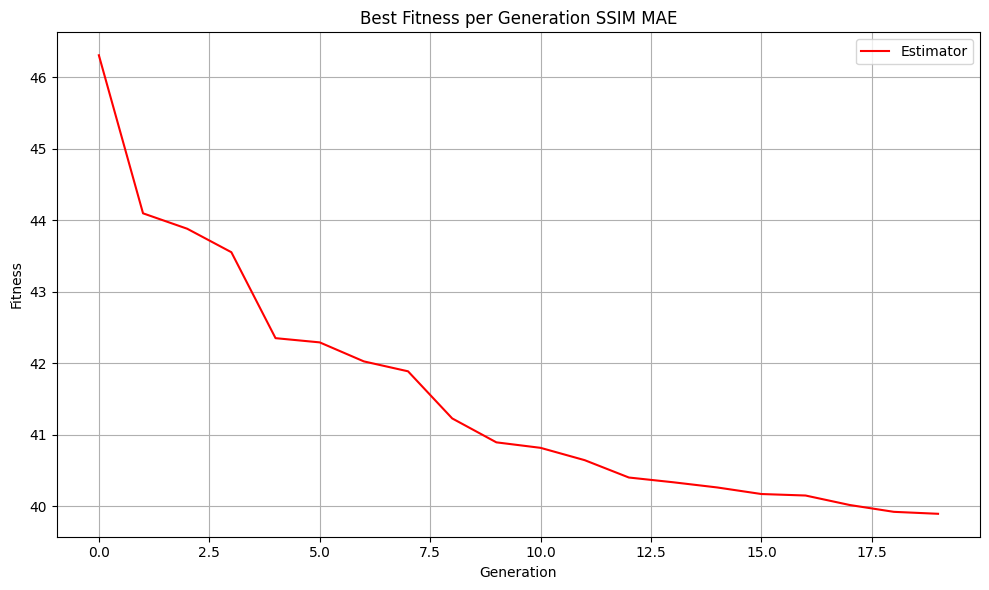

In [16]:
plot_fitness(complete_est, 20, "SSIM MAE")

In [17]:
print(complete_est._program)

mul_255(cos(ic(X1, mul_255(ic(X1, X1, X1, X0, X0)), mul_255(cos(cos(ic(X1, mul_255(ic(X1, X1, X1, X0, X0)), mul_255(cos(cos(ic(ic(ic(ic(mul_255(cos(cos(res_x(X2)))), res_x(X2), X0, X1, sin(res_x(X2))), res_x(X2), X0, X1, sin(mul_255(cos(X2)))), res_x(X2), X0, X1, X2), res_x(X2), X0, X1, cos(mul_255(cos(cos(res_x(X2))))))))), cos(ic(res_x(X2), X1, X1, X0, X0)), X0)))), cos(ic(res_x(X2), X1, X1, X0, X0)), X0)))


In [18]:
print(complete_est._program)

mul_255(cos(ic(X1, mul_255(ic(X1, X1, X1, X0, X0)), mul_255(cos(cos(ic(X1, mul_255(ic(X1, X1, X1, X0, X0)), mul_255(cos(cos(ic(ic(ic(ic(mul_255(cos(cos(res_x(X2)))), res_x(X2), X0, X1, sin(res_x(X2))), res_x(X2), X0, X1, sin(mul_255(cos(X2)))), res_x(X2), X0, X1, X2), res_x(X2), X0, X1, cos(mul_255(cos(cos(res_x(X2))))))))), cos(ic(res_x(X2), X1, X1, X0, X0)), X0)))), cos(ic(res_x(X2), X1, X1, X0, X0)), X0)))


In [19]:
print(complete_est._program)

mul_255(cos(ic(X1, mul_255(ic(X1, X1, X1, X0, X0)), mul_255(cos(cos(ic(X1, mul_255(ic(X1, X1, X1, X0, X0)), mul_255(cos(cos(ic(ic(ic(ic(mul_255(cos(cos(res_x(X2)))), res_x(X2), X0, X1, sin(res_x(X2))), res_x(X2), X0, X1, sin(mul_255(cos(X2)))), res_x(X2), X0, X1, X2), res_x(X2), X0, X1, cos(mul_255(cos(cos(res_x(X2))))))))), cos(ic(res_x(X2), X1, X1, X0, X0)), X0)))), cos(ic(res_x(X2), X1, X1, X0, X0)), X0)))


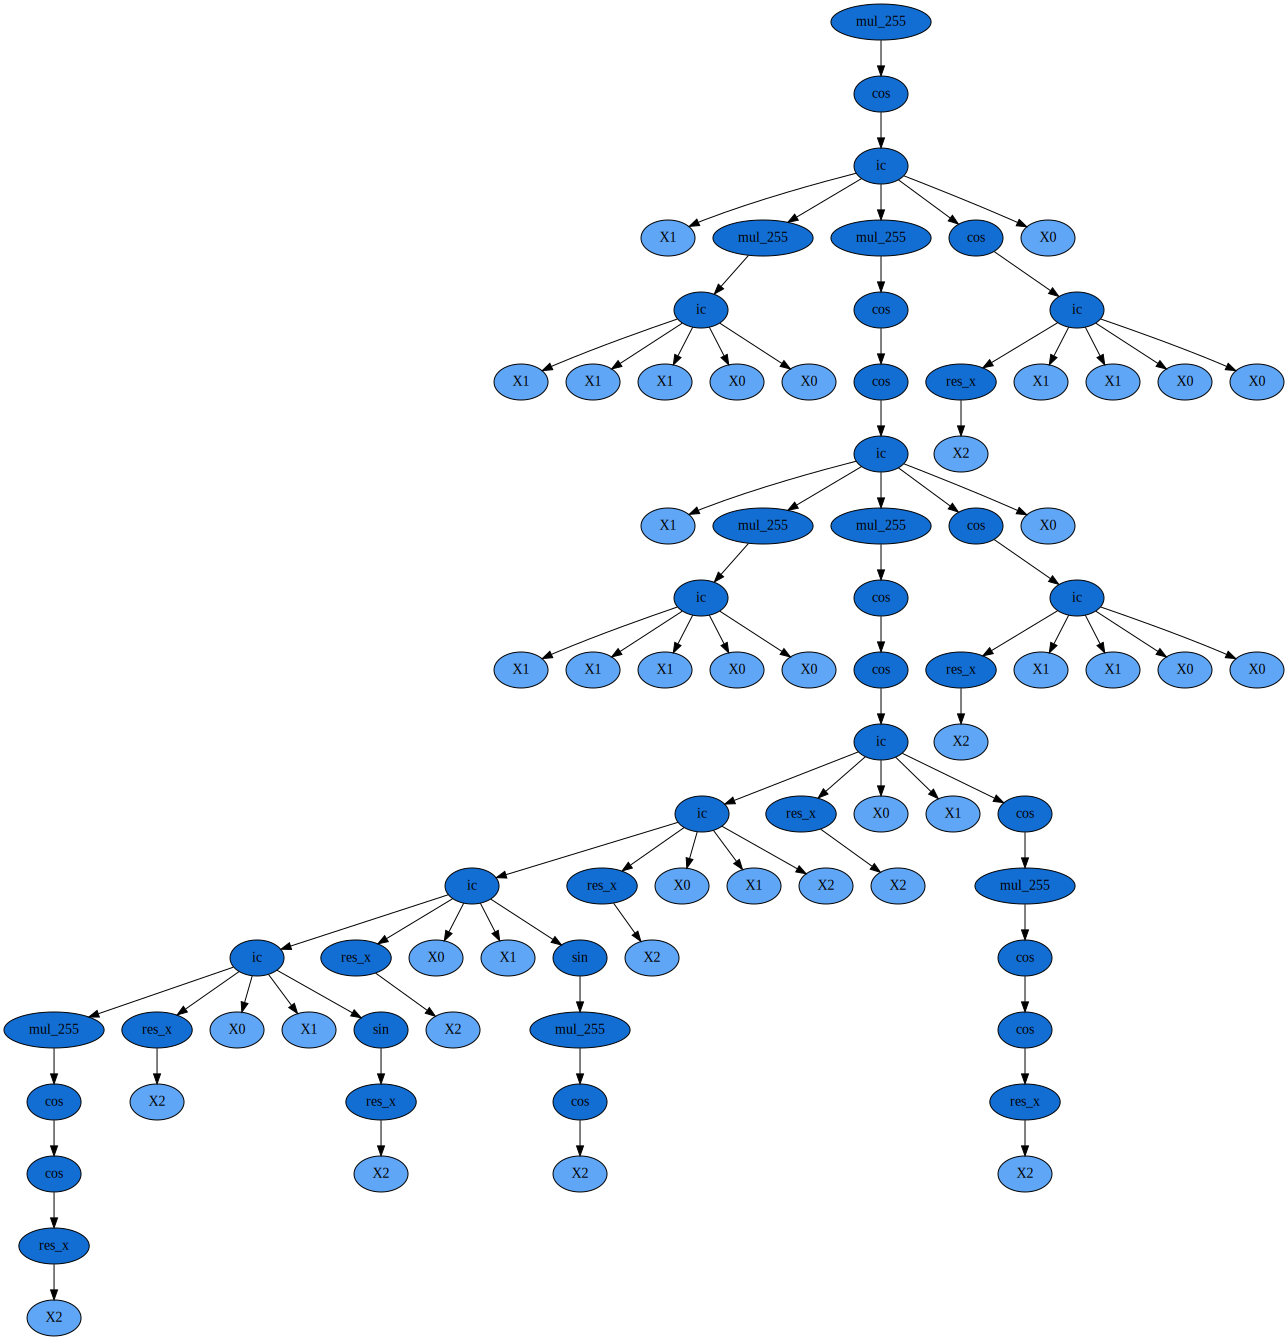

In [20]:
dot_data = complete_est._program.export_graphviz()
graph = graphviz.Source(dot_data)
graph

In [21]:
complete_est.run_details_.keys()

dict_keys(['generation', 'average_length', 'average_fitness', 'best_length', 'best_fitness', 'best_oob_fitness', 'generation_time'])